# Pog/Kappa Meter

The aim of this project is to provide a "Pog vs Kappa" comparison for each streamer's channel over a given period of time and use these labels to analyze sentiment. Emotes of type "Pog" correspond to excitement, whereas "Kappa" corresponds to sarcasm. We can think of these emotes as measure of enjoyment versus playfulness for a streamer's channel. Ideally, we would be able to measure sentiment by capturing emotes that show enjoyment, but sometimes emotes are used sarcastically. For example, it is not uncommon to see both of the following comments:
> First place! PogChamp

> Last place! PogChamp

Clearly, the last comment is sarcastic. In order to account for this, we measure the "troll-y-ness" of the channel.

Once we create a model to predict the emotes, we will evaluate the sentiment of chatrooms by counting appearances of emotes explicity written in messages as well as classifying text without emotes using our neural network.

The main difficulty in building a sentiment classifier for chat room messages is the noisiness of the data. There are several grammatical errors, "trolling" messages, spam messages, and sarcastic messages. Our model makes a first attempt at building a reasonable classifier, but it can be improved by further preprocessing and carefully selecting emote groups.

## Table of Contents

1. [Preprocessing](##preprocessing)
2. [Embedding](##embedding)
3. [Learning](##learning)
4. [Sentiment Analysis](##sentiment)

In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/

Mounted at /content/drive
/content/drive/My Drive


In [ ]:
import pandas as pd
import os
import string
import re
import requests
import json
import twokenize
import pickle
import numpy as np
from datetime import datetime

### Preprocessing

In order to properly train our data, we will need to combine the 52 pickled data sets into one large data set, which is over 12 GB. Since the size is too large for memory, we will have to preprocess each data set individually, and preprocess chunks of the individual data sets themselves when they are too large. To carry this out, we saved our pickled files as csv files since ```pandas``` can read csv files piece by piece, whereas pickled files cannot be read in this way. (In the end, this was unnecessary, but we chose to save our files to csv anyway.)

The goal of our preprocessing step is to filter unwanted messages while also labeling the messages according to the emotes used. We first load in our list of streamers, which were obtained manually. They are listed by size in descending order.

In [ ]:
streamers = pickle.load(open("streamers.pkl", "rb"))
streamers[:5]

['sodapoppin', 'shroud', 'lirik', 'moonmoon_ow', 'ninja']

We load the pickled files one by one, selecting only the columns that may be useful later on. This reduces the size of the data by 25%.

In [ ]:
for streamer in streamers:
  print(streamer)
  df = pd.read_pickle(streamer+'.pkl')
  df = df.drop(columns=['updated_at', 'commenter_type', 'offset', 'video_id', 'commenter_id'])
  df.to_csv(streamer + '_trim.csv')
  del df

sodapoppin


Once we have trimmed the size our data set and saved the dataframes to csv files, we are ready to start preprocessing our data. We will create a function that preprocesses any dataframe given to it. Our goal is to remove any hyperlinks, non-ASCII characters, tokenize the data. We choose to leave punctuation in our text since there is some benefit for our models.

In [ ]:
def process_df(df):
    df['body'] = df['body'].apply(lambda x: re.sub("http\S+|[^\x00-\x7F]|\@[a-zA-Z0-9]+", "", str(x)))
    df['body'] = df['body'].apply(lambda x: x.translate(x.maketrans('', '', string.punctuation)))
    df['body'] = df['body'].apply(lambda x: x.lower())
    df['tokens_body'] = df['body'].apply(lambda x: twokenize.tokenizeRawTweetText(x))
    df['counts'] = df['tokens_body'].apply(lambda x: len(x))
    df['u_counts'] = df['tokens_body'].apply(lambda x: len(set(x)))
    
    # Remove sentences with fewer than 5 unique words. We will apply a modified version of this filter again later on.
    df = df[df['u_counts'] >= 5]
    df['date'] = df['created_at'].apply(lambda x: datetime.strptime(datetime.strftime(x, '%Y %m %d %H'), '%Y %m %d %H'))
    
    return df[['date','body','tokens_body']]

In [ ]:
for streamer in streamers:
    df = pd.read_csv('trimmed_data/' + streamer + '_trim.csv', usecols=['body','created_at'], parse_dates=['created_at'])
    df = process_df(df)
    df.to_csv('lower_data/' + streamer +'_lower.csv')
    print(streamer, " processed.")
    del df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


sodapoppin  processed.
shroud  processed.
lirik  processed.
moonmoon_ow  processed.
ninja  processed.
forsen  processed.
admiralbahroo  processed.
nl_kripp  processed.
xqcow  processed.
loltyler1  processed.
singsing  processed.
maximilian_dood  processed.
cohhcarnage  processed.
dansgaming  processed.
admiralbulldog  processed.
b0aty  processed.
nickmercs  processed.
dafran  processed.
imaqtpie  processed.
sypherpk  processed.
disguisedtoasths  processed.
summit1g  processed.
tsm_hamlinz  processed.
giantwaffle  processed.
joshog  processed.
timthetatman  processed.
thijshs  processed.
drlupo  processed.
goldglove  processed.
quin69  processed.
tsm_myth  processed.
dakotaz  processed.
highdistortion  processed.
shiphtur  processed.
voyboy  processed.
xchocobars  processed.
cryaotic  processed.
aimbotcalvin  processed.
chocotaco  processed.
c9sneaky  processed.
tsm_viss  processed.
kinggothalion  processed.
scarra  processed.
iwilldominate  processed.
tfue  processed.
grimmmz  processe

We will request the list of emotes from Twitch using an api. This can only be used to grab global emotes and streamer-specific emotes. Global emotes are not as popular as they once were, but still common enough that they should be used. Streamer-specific emotes are emotes accessible only to paid subscribers to a channel and are frequently used. The last group of emotes is obtained manually from [FrankerFaceZ](https://www.frankerfacez.com/emoticons/). These emotes are similar in function to the global emotes and have since replaced them. We only use the 100 most popular emotes used on Twitch.

Emotes serve two purposes: 

*   They provide a way to label our data and classify sentiment, similar to techniques used for Twitter sentiment analysis. (See [Towards the Understanding of Gaming Audiences by Modeling Twitch Emotes](https://pdfs.semanticscholar.org/1260/f76d10ec66dda257070ce4dcdbab800ec501.pdf)).
*   We will need to filter these emotes out of the so that our model cannot cheat, and also to filter out noise in our messages.



In [ ]:
# Get global emotes. Some have become less popular in favor of FrankerFace emotes.

global_response = requests.get('https://api.twitch.tv/kraken/chat/emoticon_images?emotesets=0', headers={
                               'Accept': 'application/vnd.twitchtv.v5+json', 'Client-ID': '4f7ls48eaq2lly25dyuiead8o5ydev'})
json_data_global = json.loads(global_response.text)
global_emotes = json_data_global.get('emoticon_sets').get('0')
global_emotes = set([i.get("code").lower() for i in global_emotes])

In [ ]:
# Function for grabbing emotes specific to a particular streamer. Only subscribers to the streamer's channel can use these.

def streamer_emotes(streamer):
    channel_ids = pickle.load(open('channel_ids.pkl', 'rb'))
    response = requests.get('https://api.twitchemotes.com/api/v4/channels/' + channel_ids[streamer])
    json_data = json.loads(response.text)
    emotes = json_data.get("emotes")
    X = set([i.get("code") for i in emotes])

    return X

In [ ]:
# Load top 96 FrankerFaceZ emotes.
topffemotes = set([i.lower() for i in pickle.load(open('top100ffemotes.pkl', 'rb'))])


In this final preprocessing step, we will label our data and filter emotes from our tokens. From here, we will be able to use these dataframes for our word embeddings.

In [ ]:
def process_tokens(streamer):
  df = pd.read_csv('lower_data/' + streamer + '_lower.csv', parse_dates=['date'])

  kappas = {'kapp', 'kappa', 'kappaclaus', 'kappapride', 'kappaross', 'kappawealth', 'kappu', 'keepo'}
  pogs = {'poggers','pog','pogchamp','pogu','pogyou','pogey'}

  X = global_emotes.union(streamer_emotes(streamer)).union(topffemotes)
  df['tokens_body'] = df['tokens_body'].apply(lambda x: eval(x))
  df['unique emotes'] = df['tokens_body'].apply(set)
  df['unique emotes'] = df['unique emotes'].apply(lambda x: x.intersection(set(X)))

  df['emote_counts'] = df['unique emotes'].apply(lambda x: len(x))
  df_filt = df[df['emote_counts'] > 0]

  df_filt['pog'] = df_filt['unique emotes'].apply(lambda x: 1 if len(x.intersection(pogs)) > 0 else 0)
  df_filt['kappa'] = df_filt['unique emotes'].apply(lambda x: 1 if len(x.intersection(kappas)) > 0 else 0)
  df_filt['mix'] = df_filt['pog'] + df_filt['kappa']
  df['u'] = df['tokens_body'].apply(lambda x: len(set(x)))
  df_filt = df_filt[df_filt['mix'] <= 1]
  df_filt['other'] = df_filt['mix'].apply(lambda x: 1 if x == 0 else 0)

  df_filt['tokens_minus_emotes'] = df_filt['tokens_body'].apply(lambda x: [i for i in x if i not in X])
  df_filt['u'] = df_filt['tokens_minus_emotes'].apply(lambda x: len(set(x)))
  df_filt = df_filt[df_filt['u'] >= 5]
  df_filt = df_filt.drop_duplicates(subset=['body'])
  df_filt['body_short'] = df_filt['tokens_minus_emotes'].apply(lambda x: ' '.join(x[:8]))
  df_filt = df_filt.drop_duplicates(subset=['body_short'])

  df_filt = df_filt[['date','tokens_minus_emotes','unique emotes','pog','kappa','other']]
  df_filt.to_csv('lower_processed/' + streamer + '_lowerproc.csv')

In [ ]:
streamers = pickle.load(open("streamers.pkl", "rb"))
for streamer in streamers:
  process_tokens(streamer)
  print(streamer + " processed.")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

sodapoppin processed.
shroud processed.
lirik processed.
moonmoon_ow processed.
ninja processed.
forsen processed.
admiralbahroo processed.
nl_kripp processed.
xqcow processed.
loltyler1 processed.
singsing processed.
maximilian_dood processed.
cohhcarnage processed.
dansgaming processed.
admiralbulldog processed.
b0aty processed.
nickmercs processed.
dafran processed.
imaqtpie processed.
sypherpk processed.
disguisedtoasths processed.
summit1g processed.
tsm_hamlinz processed.
giantwaffle processed.
joshog processed.
timthetatman processed.
thijshs processed.
drlupo processed.
goldglove processed.
quin69 processed.
tsm_myth processed.
dakotaz processed.
highdistortion processed.
shiphtur processed.
voyboy processed.
xchocobars processed.
cryaotic processed.
aimbotcalvin processed.
chocotaco processed.
c9sneaky processed.
tsm_viss processed.
kinggothalion processed.
scarra processed.
iwilldominate processed.
tfue processed.
grimmmz processed.
kingrichard processed.
followgrubby process

## Embeddings

The inputs for our neural network must be ```numpy``` arrays, so we will need to use word embeddings to vectorize our inputs. While we can train our own embedding layer in ```keras```, we find that better performance can be obtained using pre-trained embedding models.

One of the most common embedding models for NLP tasks is Google's Word2Vec. However, Word2Vec does not handle mispellings well, which can be an issue for processing chat room messages. Facebook's fastText is a more general model that learns character n-grams along with the word embedding as in Word2Vec. We will use fastText through the ```gluonnlp``` package.

We load in our data from the preprocessing stage.

In [ ]:
streamers = pickle.load(open("streamers.pkl", "rb"))
df = pd.DataFrame()
for streamer in streamers:
  df_temp = pd.read_csv('lower_processed/' + streamer + '_lowerproc.csv', parse_dates=['date'])
  df = pd.concat([df,df_temp])
df

,Unnamed: 0,date,tokens_minus_emotes,unique emotes,pog,kappa,other
0,5,2018-05-20 20:00:00,"['vod', 'frogs', 'whisper', 'me', 'if', 'you',...",{'heyguys'},0,0,1
1,6,2018-05-20 20:00:00,"['hurry', 'up', 'with', 'your', 'jerking', 'he...",{'pog'},1,0,0
2,8,2018-05-20 20:00:00,"['its', 'still', 'hosting', 'forsen', 'for', '...",{'monkas'},0,0,1
3,11,2018-05-20 20:00:00,"['hey', 'myself', 'on', 'stream', 'sodah']",{'pog'},1,0,0
4,35,2018-05-20 20:00:00,"['vod', 'grills', 'hit', 'me', 'up', 'vod', 'g...",{'kreygasm'},0,0,1
...,...,...,...,...,...,...,...
5610,50146,2018-06-22 00:00:00,"['still', 'playing', 'this', 'deck', 'with', '...",{'feelsgoodman'},0,0,1
5611,50154,2018-06-22 00:00:00,"['if', 'only', 'i', 'could', 'hit', 'the', 'el...",{'feelsbadman'},0,0,1
5612,50170,2018-06-22 00:00:00,"['thatll', 'be', 'it', 'for', 'me', 'today']",{'feelsbadman'},0,0,1
5613,50181,2018-06-22 00:00:00,"['type', '1', 'if', 'you', 'would', 'kibler']",{'kappapride'},0,1,0


In [ ]:
# Frequency of labels in our data
labels = ['pog','kappa','other']
for label in labels:
    print(df[label].sum())

111219
185448
1235651


As we can see, messages are more frequently not of "pog" or "kappa" type, so we will need to sample our data so our model does not learn to simply guess "other" for every message. Another alternative is to use SMOTE, but after experimentation we found undersampling data is better for performance.

We will uniformize the length of our tokenized sentences to 12 tokens.

In [ ]:
df['tokens_minus_emotes'] = df['tokens_minus_emotes'].apply(lambda x: eval(x))
df['pad_tokens'] = df['tokens_minus_emotes'].apply(lambda x: x[:12] if len(x) >= 12 else x+['']*(12-len(x)))

There are several choices for pre-trained fastText models, but we chose the default model due to size contraints.

In [ ]:
!pip install gluonnlp
!pip install mxnet

     |████████████████████████████████| 348kB 2.7MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp36-cp36m-linux_x86_64.whl size=588513 sha256=9780e4b80b60e92ce7b125e4dc801cda0ddcd5a32ee9a2a675252cd57ae8e271
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
     |████████████████████████████████| 55.0MB 56kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
import gluonnlp as nlp
import mxnet as mx

fasttext = nlp.embedding.create('fasttext', source='wiki.simple', load_ngrams=True)
tokenized = [i for i in df['pad_tokens']]
tokens = [i for sub in tokenized for i in sub]
counter = nlp.data.count_tokens(tokens)
my_vocab = nlp.Vocab(counter)
my_vocab.set_embedding(fasttext)

Embedding file wiki.simple-67424112.bin is not found. Downloading from Gluon Repository. This may take some time.


We sample our data and save the embeddings since they take quite some time to create. The embeddings are 9 GB in total, and Google Colab limits the size of files that can be saved, so we split the embeddings into 3 chunks.

In [ ]:
df_pog = df[df['pog'] == 1]
df_kappa = df[df['kappa'] == 1]
df_other = df[df['other'] == 1]

n = 110000
df_pograndom = df_pog.sample(n)
df_kapparandom = df_kappa.sample(n)
df_otherrandom = df_other.sample(n)

df_sample = pd.concat([df_pograndom,df_kapparandom,df_otherrandom]).sample(frac=1)

In [ ]:
subset_tokenized = [i for i in df_sample['pad_tokens']]
embeddings = [my_vocab.embedding[i].asnumpy() for i in subset_tokenized]
embeddings = np.array(embeddings)

In [ ]:
pickle.dump(embeddings[:110000],open("embeddings_array_lower_0.pkl", "wb"))
pickle.dump(embeddings[110000:220000],open("embeddings_array_lower_1.pkl", "wb"))
pickle.dump(embeddings[220000:],open("embeddings_array_lower_2.pkl", "wb"))

## Learning

We now move to creating and training our model. It is well-known that LSTM layers work better than other layers such as convolutional layers for NLP tasks due its ability to account for long term word dependencies as well as short toerm dependencies (hence the name Long Short-Term Memory). Bi-directional LSTM layers improve upon LSTM layers by taking into account word dependencies that arise after a word appears in text, as opposed to simply looking at words appearing before the word in a traditional LSTM layer. 

In [ ]:
X_0 = pickle.load(open("embeddings_array_lower_0.pkl", "rb"))
X_1 = pickle.load(open("embeddings_array_lower_1.pkl", "rb"))
X_2 = pickle.load(open("embeddings_array_lower_2.pkl", "rb"))

In [ ]:
X = np.concatenate((X_0,X_1,X_2),axis=0)

# X = embeddings

In [ ]:
del X_0
del X_1
del X_2

In [ ]:
y = df_sample[['pog','kappa','other']].values
# Saving y values is important due to connection with sampled data. Otherwise, labels will not correspond to the correct text if y values are obtained from repeating sampling steps above.
pickle.dump(y,open("train_lower_labels.pkl","wb"))

In [ ]:
y = pickle.load(open("train_lower_labels.pkl","rb"))

In [ ]:
# Split our data into train and test data.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [ ]:
# X variable no longer needed.
del X

In [ ]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Flatten, Input, BatchNormalization, Concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
# from keras.optimizers import RMSprop
from keras.regularizers import l2
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import Model

We found more complicated models were not as effective. The validation accuracy of our model hovers at almost 57% if we reduce our learning rate to 0.001,  reduce the dropout rate, and use only one bidirectional LSTM layer.

In [ ]:
X_train.shape

(264000, 12, 300)

In [ ]:
# model1 = Sequential()
# model1.add(Bidirectional(LSTM(128,activation='relu',return_sequences=True),input_shape=(20, 300)))
# model1.add(Dropout(0.5))
# model1.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
# model1.add(MaxPooling1D(pool_size=2))
# model1.add(Dropout(0.5))
# model1.add(BatchNormalization())
# model1.add(LSTM(128,activation='relu',return_sequences=True))

# model2 = Sequential()
# model2.add(Bidirectional(LSTM(128,activation='relu',return_sequences=True),input_shape=(20, 300)))
# model2.add(Dropout(0.5))
# model2.add(Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)))
# model2.add(MaxPooling1D(pool_size=2))
# model2.add(Dropout(0.5))
# model2.add(BatchNormalization())
# model2.add(LSTM(128,activation='relu',return_sequences=True))

# model3 = Sequential()
# model3.add(Bidirectional(LSTM(128,activation='relu',return_sequences=True),input_shape=(20, 300)))
# model3.add(Dropout(0.5))
# model3.add(Conv1D(filters=128, kernel_size=7, activation='relu', kernel_regularizer=l2(0.01)))
# model3.add(MaxPooling1D(pool_size=2))
# model3.add(Dropout(0.5))
# model3.add(BatchNormalization())
# model3.add(LSTM(128,activation='relu',return_sequences=True))

# model4 = Sequential()
# model4.add(Bidirectional(LSTM(128,activation='relu',return_sequences=True),input_shape=(20, 300)))
# model4.add(Dropout(0.5))
# model4.add(Conv1D(filters=128, kernel_size=9, activation='relu', kernel_regularizer=l2(0.01)))
# model4.add(MaxPooling1D(pool_size=2))
# model4.add(Dropout(0.5))
# model4.add(BatchNormalization())
# model4.add(LSTM(128,activation='relu',return_sequences=True))

# merged = Concatenate(axis=1)([model1.output,model2.output,model3.output,model4.output])
# merged = Bidirectional(LSTM(128,activation='relu',return_sequences=True))(merged)
# merged = Dropout(0.5)(merged)
# merged = Bidirectional(LSTM(128,activation='relu',return_sequences=False))(merged)
# merged = Dropout(0.5)(merged)
# merged = Dense(128, activation='relu')(merged)
# merged = Dropout(0.5)(merged)
# merged = Dense(3, activation='softmax')(merged)
# model = Model([model1.input,model2.input,model3.input,model4.input], merged)

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(128,activation='relu',return_sequences=True),input_shape=(12, 300)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128,activation='relu',return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [ ]:
from tensorflow import keras
from keras.callbacks import ModelCheckpoint

checkpoint_filepath = '/content/drive/My Drive/saved_models'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_freq="epoch",
    monitor='val_acc',
    mode='max',
    save_best_only=True)

opt = keras.optimizers.Adam(learning_rate=0.001)
# compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

# fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10, verbose=1, callbacks=[model_checkpoint_callback])

Epoch 1/10
8250/8250 [==============================] - ETA: 0s - loss: 1.0245 - acc: 0.4739

8250/8250 [==============================] - 513s 62ms/step - loss: 1.0245 - acc: 0.4739 - val_loss: 0.9815 - val_acc: 0.5089
Epoch 2/10
8250/8250 [==============================] - ETA: 0s - loss: 0.9809 - acc: 0.5138

8250/8250 [==============================] - 415s 50ms/step - loss: 0.9809 - acc: 0.5138 - val_loss: 0.9675 - val_acc: 0.5202
Epoch 3/10
8249/8250 [============================>.] - ETA: 0s - loss: 0.9609 - acc: 0.5324

8250/8250 [==============================] - 364s 44ms/step - loss: 0.9609 - acc: 0.5324 - val_loss: 0.9604 - val_acc: 0.5311
Epoch 4/10
8250/8250 [==============================] - ETA: 0s - loss: 0.9458 - acc: 0.5456

8250/8250 [==============================] - 356s 43ms/step - loss: 0.9458 - acc: 0.5456 - val_loss: 0.9523 - val_acc: 0.5344
Epoch 5/10
8250/8250 [==============================] - ETA: 0s - loss: 0.9357 - acc: 0.5548

8250/8250 [==============================] - 374s 45ms/step - loss: 0.9357 - acc: 0.5548 - val_loss: 0.9474 - val_acc: 0.5390
Epoch 6/10
8250/8250 [==============================] - 375s 45ms/step - loss: 1.1238 - acc: 0.5007 - val_loss: 1.1124 - val_acc: 0.3427
Epoch 7/10
8250/8250 [==============================] - 376s 46ms/step - loss: 1.1957 - acc: 0.3346 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 8/10
8250/8250 [==============================] - 357s 43ms/step - loss: 1.1315 - acc: 0.3322 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 9/10
8250/8250 [==============================] - 352s 43ms/step - loss: 1.1449 - acc: 0.3335 - val_loss: 1.0987 - val_acc: 0.3333
Epoch 10/10
8250/8250 [==============================] - 358s 43ms/step - loss: 1.1259 - acc: 0.3318 - val_loss: 1.0987 - val_acc: 0.3333


In [ ]:
model.save("BLSTM_1layer_128_nodense_001_dropout_2_history_09282022")

In [ ]:
# Save the history of model.
pickle.dump(history.history,open("BLSTM_1layer_128_nodense_001_dropout_2_history_09282022.pkl","wb"))

In [ ]:
from keras import models
model = models.load_model('/content/drive/My Drive')

Let us see how our model does on some typical phrases one might encounter in a Twitch chat room.

In [ ]:
def pad_tokens(tokens):
  if len(tokens) <= 20:
    return tokens + ['']*(20-len(tokens))
  else:
    return tokens[:20]

In [ ]:
import twokenize

some_sentences = ['ur a god', 'genius', 'ur trash', 'woah', 'amazing', 'legendary', 'omg', 'never seen someone so bad in my life']
some_tokenized_sentences = [twokenize.tokenizeRawTweetText(x) for x in some_sentences]
for sentence in some_tokenized_sentences:
  x = pad_tokens(sentence)
  print(model.predict(my_vocab.embedding[x].asnumpy().reshape((1,20,300))))

[[0.77403605 0.09540284 0.13056114]]
[[0.8009759  0.03310856 0.16591558]]
[[0.18588904 0.2549253  0.5591857 ]]
[[0.87675494 0.01605768 0.10718743]]
[[0.74187857 0.05576096 0.20236053]]
[[0.9318048  0.01210221 0.05609291]]
[[0.52967215 0.0873668  0.38296103]]
[[0.26790887 0.34094304 0.39114812]]


In the simple examples given above, we can see that the model correctly classifies every message. One possible reason for the somewhat poor model performance overall is that we were unable to filter our messages enough. Another reason, one which likely has a more significant effect, is that the "other" category is too ambiguous, and likely contains emotes that are similar in function to "pog"-type and "kappa"-type emotes. We will perform a check using a confusion matrix.

In [ ]:
!pip install bokeh

In [ ]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

output_notebook()

In [ ]:
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

In [ ]:
import matplotlib.font_manager
set([f.name for f in matplotlib.font_manager.fontManager.ttflist])

{'DejaVu Sans',
 'DejaVu Sans Display',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'DejaVu Serif Display',
 'Humor Sans',
 'Liberation Mono',
 'Liberation Sans',
 'Liberation Sans Narrow',
 'Liberation Serif',
 'STIXGeneral',
 'STIXNonUnicode',
 'STIXSizeFiveSym',
 'STIXSizeFourSym',
 'STIXSizeOneSym',
 'STIXSizeThreeSym',
 'STIXSizeTwoSym',
 'cmb10',
 'cmex10',
 'cmmi10',
 'cmr10',
 'cmss10',
 'cmsy10',
 'cmtt10'}

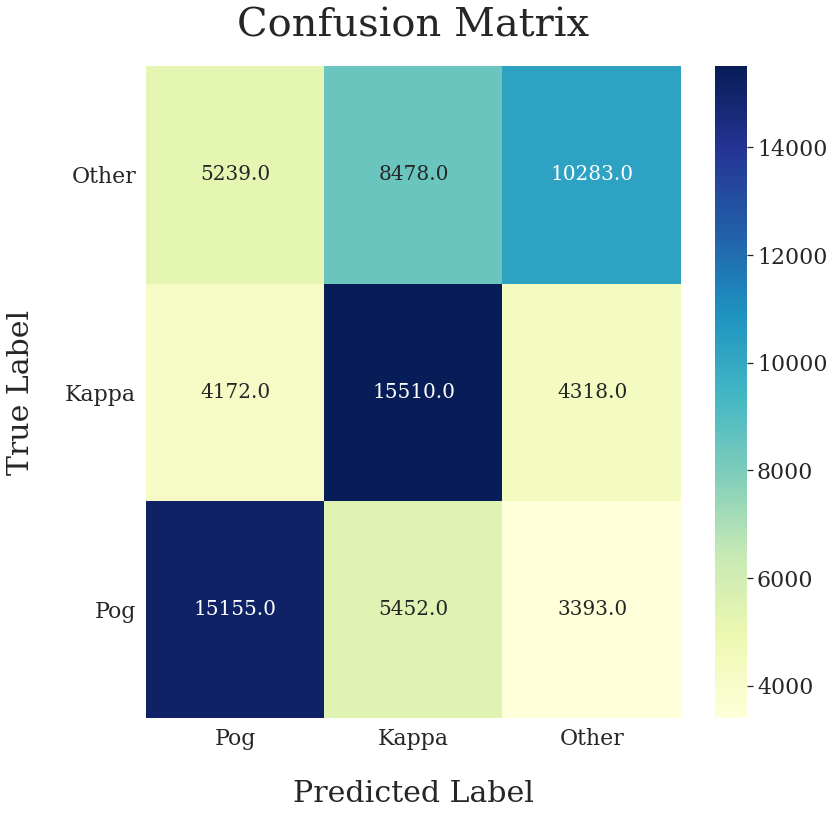

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# confusion = confusion_matrix(y_true, y_pred_class)
confusion = np.array([[15155,  5452,  3393],
                      [ 4172, 15510,  4318],
                      [ 5239,  8478, 10283]])

f, ax = plt.subplots(figsize= (12,12))

labels = ["Pog", "Kappa", "Other"]
sns.heatmap(confusion, xticklabels=labels, yticklabels=labels, annot = True, cmap = "YlGnBu", fmt= '.1f', annot_kws={"fontsize":20})

plt.yticks(rotation=0)

ax.invert_yaxis()
ax.set_title("Confusion Matrix", fontname='DejaVu Serif', fontsize=40, pad=30)
ax.set_xlabel("Predicted Label", fontname='DejaVu Serif', fontsize=30, labelpad=30)
ax.set_ylabel("True Label", fontname='DejaVu Serif', fontsize=30, labelpad=30)

plt.rcParams['font.family'] = "DejaVu Serif"

plt.show()
# plt.savefig('cm.png')

In [ ]:
history = pickle.load(open("BLSTM_1layer_128_nodense_001_dropout_2_history.pkl","rb"))
history

{'acc': [0.5243333578109741,
  0.5579652786254883,
  0.5755521059036255,
  0.590996503829956,
  0.6064131855964661,
  0.6225903034210205,
  0.640701413154602,
  0.6516110897064209,
  0.6650694608688354,
  0.6792430281639099],
 'loss': [0.5566859245300293,
  0.5336248278617859,
  0.5221971273422241,
  0.5083720088005066,
  0.4958172142505646,
  0.4828302264213562,
  0.4663048982620239,
  0.45513129234313965,
  0.4425618350505829,
  0.42758190631866455],
 'val_acc': [0.5508055686950684,
  0.5596944689750671,
  0.5660971999168396,
  0.5687222480773926,
  0.5659999847412109,
  0.5646944642066956,
  0.566444456577301,
  0.5605972409248352,
  0.5617361068725586,
  0.5575000047683716],
 'val_loss': [0.5370073914527893,
  0.5318731069564819,
  0.5268410444259644,
  0.5263255834579468,
  0.5321478247642517,
  0.5384119749069214,
  0.5408296585083008,
  0.5531864762306213,
  0.5651594996452332,
  0.5729269981384277]}

In [ ]:
from IPython.display import Image
from bokeh.io import export_png
from bokeh.io.export import get_screenshot_as_png
x = [i for i in range(1,11)]
y = history['val_acc']
p = figure(plot_height=500, plot_width=1000,
            title="Validation Accuracy by Epoch", tools="save")
p.line(x, y, line_width=4)
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.xaxis.axis_label = "Epochs"
p.yaxis.axis_label = "Validation Accuracy"
p.xaxis.major_label_orientation = 1
p.title.text_font_size = '20pt'

p.yaxis.axis_label_text_font_size = "20pt"
p.yaxis.major_label_text_font_size = "15pt"
p.xaxis.axis_label_text_font_size = "20pt"
p.xaxis.major_label_text_font_size = "15pt"

show(p)

In [ ]:
x = [i for i in range(1,11)]
y = history['val_loss']
p = figure(plot_height=500, plot_width=1000,
            title="Validation Loss by Epoch", tools="save")
p.line(x, y, line_width=4)
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.xaxis.axis_label = "Epochs"
p.yaxis.axis_label = "Validation Loss"
p.xaxis.major_label_orientation = 1
p.title.text_font_size = '25pt'

p.yaxis.axis_label_text_font_size = "20pt"
p.yaxis.major_label_text_font_size = "15pt"
p.xaxis.axis_label_text_font_size = "20pt"
p.xaxis.major_label_text_font_size = "15pt"
show(p)

# Unfinished

## Sentiment Analysis

We are finally ready to analyze the sentiment of chat rooms. Our first step will be to compute the percentage of messages corresponding to an emote group by day. For this, we will use our full data set.

In [ ]:
df = pd.read_csv('sodapoppin_trim.csv', parse_dates=['created_at'])

In [ ]:
def process_df(streamer):
  df = pd.read_csv(streamer +'_trim.csv', parse_dates=['created_at'])
  df['body'] = df['body'].apply(lambda x: re.sub("http\S+|[^\x00-\x7F]", "", str(x)))
  df['tokens_body'] = df['body'].apply(lambda x: twokenize.tokenizeRawTweetText(x))
  df['date'] = df['created_at'].apply(lambda x: datetime.strptime(datetime.strftime(x, '%Y %m %d %H'), '%Y %m %d %H'))

  X = global_emotes.union(streamer_emotes(streamer)).union(topffemotes)
  df['unique_emotes'] = df['tokens_body'].apply(set)
  df['unique_emotes'] = df['unique_emotes'].apply(lambda x: x.intersection(set(X)))
  df['count_emotes'] = df['unique_emotes'].apply(lambda x: len(x))

  kappas = {'Kapp', 'Kappa', 'KappaClaus', 'KappaPride', 'KappaRoss', 'KappaWealth', 'Kappu', 'Keepo'}
  pogs = {'POGGERS','Pog','PogChamp','PogU','PogYou','Pogey'}

  df['kappa'] = df['unique_emotes'].apply(lambda x: 1 if len(x.intersection(kappas)) > 0 else 0)
  df['pog'] = df['unique_emotes'].apply(lambda x: 1 if len(x.intersection(pogs)) > 0 else 0)
  df['pog'] = df['kappa'].apply(lambda x: 0 if x==1)
  df_filt['mix'] = df_filt['pog'] + df_filt['kappa']
  df_filt['other'] = df_filt['mix'].apply(lambda x: 1 if x == 0 else 0)

  
  return df[['date','tokens_body', 'pog', 'kappa', 'other']]

In [ ]:
x = {'1','2'}
len(x)

## Alternative Approach

Here is an alternative approach that may be successful. Instead of grouping the emotes manually, we can try to cluster the most popular emotes using embeddings from a large pre-trained language model.

* Gather large amounts of Twitch chatroom text
* Fine-tune a pre-trained transformer model, such as BERT, on this text
  * We can filter this text by removing duplicate messages, but keeping the emotes in, since we want the model to learn about emotes
  * For efficiency reasons and helping the transformer use more context, we can concatenate messages, so we have longer inputs. Twitch messages tend to be short.
* Gather more data for embeddings. Here we follow the filtering method from before, but we simply compute embeddings without emotes
* Compare clusters of embeddings for each emote, and use a cluster similarity metric to determine if emotes are similar. Using some threshold, we determine emotes are semantically similar if their similarity surpasses the threshold.
* The label for each embedding will be the final cluster it belongs
* Then we use an additional dataset to fine-tune the model using the labels generated from the previous step. This will be split into train/validation
  * The threshold for cluster similarity is a hyperparameter that will need to be finetuned. This means that we will need to perform a crossvalidation experiment on the entire training pipeline, from generating the labels and then fine-tuning on additional data. Note this also automatically generates the number of clusters.
  * The generalization performance can be evaluated on a held-out test set
* As a last step, with a small enough number of clusters, we can assign semantic meaning to each of the clusters manually
* To evaluate the sentiment of a chatroom over time, we can try a few methods:
  * We can simply compute the relative frequency of top emotes in a group of messages of a fixed time-frame, e.g. 10 minutes, use our model-generated labels to map these emotes to the labels, and assign a sentiment score based on the distribution of labels
  * If there are not enough top emotes in a group of messages, we can additionally predict the corresponding label for messages that do not have top emotes and add that to our distribution calculation
  * We can use the latter method only if we prefer